In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF
import seaborn as sns
from scipy.spatial.distance import cdist

In [2]:
ladf = pd.read_csv('data/ladf.csv')

In [3]:
layr = ladf.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)

In [46]:
X = ladf.drop(['Year', 'Month', 'zipcode'], axis=1).values
scaler = MinMaxScaler()
X_sca = scaler.fit_transform(X)
model = KMeans(5, n_init=3)
model.fit(X_sca)
labels = model.labels_
centroids = model.cluster_centers_ 
ladf['class'] = labels
cntClass = ladf.groupby(['Year', 'Month', 'class'])['zipcode'].count().unstack().reset_index()
for cent in centroids:
    print cent

[  9.17001504e-03   7.12907946e-03   8.12084851e-03   2.27677901e-03
   5.30029006e-03   1.12526293e-02   1.09586162e-02   3.38631274e-03
   3.44639248e-03   2.36222623e-03   8.04911693e-14]
[ 0.06806532  0.05201638  0.07178593  0.02664251  0.03821219  0.08135755
  0.08158811  0.02568911  0.02421493  0.03412421  0.98778786]
[ 0.25596817  0.38447578  0.34725566  0.08734147  0.3633667   0.27592676
  0.30132049  0.3806366   0.14239611  0.14429708  0.27387268]
[ 0.19576387  0.10682773  0.12164311  0.0313703   0.10268904  0.1545717
  0.18739084  0.03093198  0.04058204  0.08170862  0.49879486]
[ 0.28229295  0.31075446  0.35758307  0.07483476  0.37076683  0.30757592
  0.30186196  0.0093423   0.11290483  0.19469357  0.25411061]


In [47]:
X_test = cntClass.drop(['Year', 'Month'], axis=1).values

In [48]:
X_test = 1.0 * X_test / X_test.sum(axis =1).reshape(-1, 1)

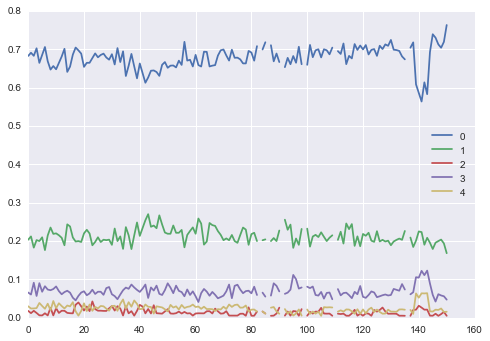

In [49]:
plt.figure()
for k in xrange(5):
    plt.plot(X_test[:,k], label= k)
plt.legend(loc='best')
plt.show()

In [8]:
layr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3813 entries, 0 to 3812
Data columns (total 12 columns):
Year       3813 non-null int64
zipcode    3813 non-null int64
1          3813 non-null float64
2          3813 non-null float64
3          3813 non-null float64
4          3813 non-null float64
5          3813 non-null float64
6          3813 non-null float64
7          3813 non-null float64
8          3813 non-null float64
9          3813 non-null float64
10         3813 non-null float64
dtypes: float64(10), int64(2)
memory usage: 357.5 KB


In [42]:
def nmf_test(df, scale=True):
    new_df = df.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)
    X = new_df.drop(['Year', 'zipcode'], axis=1).values
    if scale:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    scores = []
    dists = []
    for k in xrange(2, 11):
        model = NMF(n_components=k)
        W = model.fit_transform(X)
        labels = W.argmax(axis=1)
        H = model.components_
        dist = cdist(X, H)
        dists.append(dist.min(axis=1).sum())
        score = silhouette_score(X, labels)
        scores.append(score)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(121)
    ax1.plot(xrange(2, 11), dists, 'b*-')
    ax1.grid(True)
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('sum of squares')
    ax2 = fig.add_subplot(122)
    ax2.plot(xrange(2, 11), scores, 'b*-')
    ax2.grid(True)
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('slihouette score')
    plt.show()


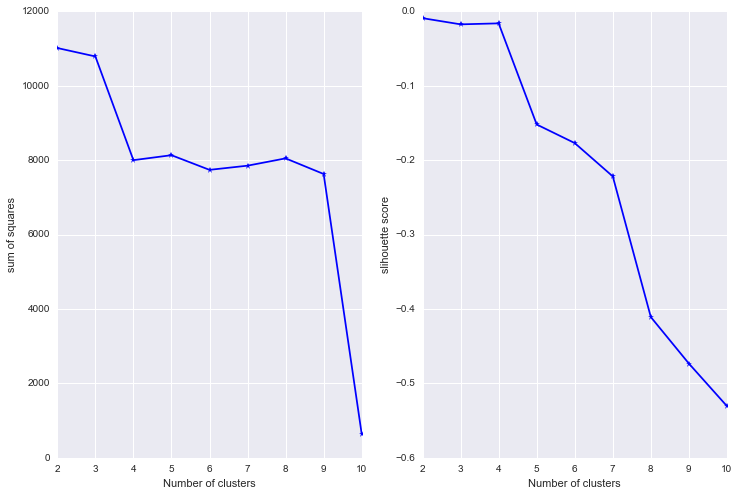

In [43]:
nmf_test(ladf)

In [83]:
crimes = {1: 'Theft/Larcery', 2: 'Robebery', 3: 'Nacotic/Alcochol',
          4: 'Assault', 5: 'Grand Auto Theft', 6: 'Vandalism',
          7: 'Burglary', 8: 'Homicide', 9: 'Sex Crime', 10: 'DUI'}

def nmf_pipline(df, k=5):
    numPost = df['zipcode'].unique().shape[0]
    new_df = df.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)
    X = new_df.drop(['Year', 'zipcode'], axis=1).values
#     print X
    scaler = MinMaxScaler()
    X_sca = scaler.fit_transform(X)
    model = NMF(n_components=k)
    W = model.fit_transform(X_sca)
    labels = W.argmax(axis=1)
    H = model.components_
    new_df['class'] = labels
    cntClass = new_df.groupby(['Year', 'class'])['zipcode'].count().unstack().reset_index()
    X_class = cntClass.drop(['Year'], axis=1).values
    X_class = 1.0 * X_class/ numPost
    years = sorted(df['Year'].unique())
    className = ['cls -{}'.format(k+1) for k in xrange(k)]
    plot_heatmap(H.T, className, k)
    plot_lines(X_class, years, className)
    plot_bars(X_class, years, className)
    plot_corr_mat(X_class, className)
    plt.show()
    return model

def plot_bars(data, years, className):    
    pd.DataFrame(data, columns=className).plot.bar(stacked=True)
    plt.xticks(range(len(years)), years)

def plot_lines(data, years, className):
    n = data.shape[1]
    plt.figure()
    for k in xrange(n):
        plt.plot(years, data[:,k], label=className[k])
    plt.legend(loc='best')
    
def plot_heatmap(data, className, k=5):
    fig, ax = plt.subplots(figsize = (8,8))
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(k)+0.5, minor=False, )
    ax.set_yticks(np.arange(10)+0.5, minor=False)
    ax.set_xticklabels(className, minor=False)
    ax.set_yticklabels(crimes.values(), minor=False)
    ax.set_title('Heatmap of Lattent Feature')
    plt.show()

def plot_corr_mat(data, className):
    # Compute the correlation matrix
    corr = pd.DataFrame(data).corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots()

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=.3,
                square=True, xticklabels=className, yticklabels=className,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

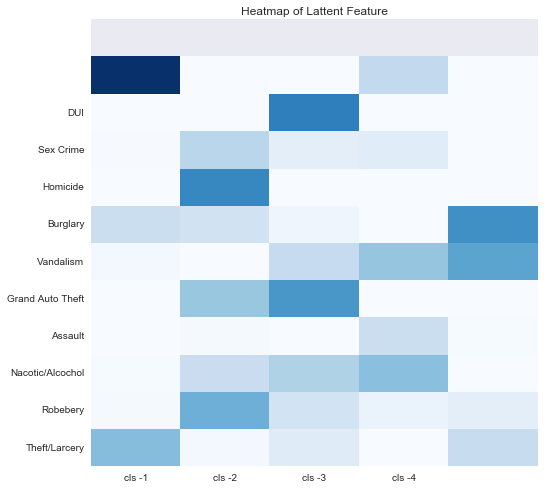

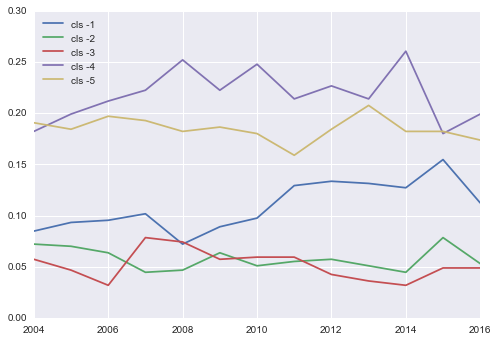

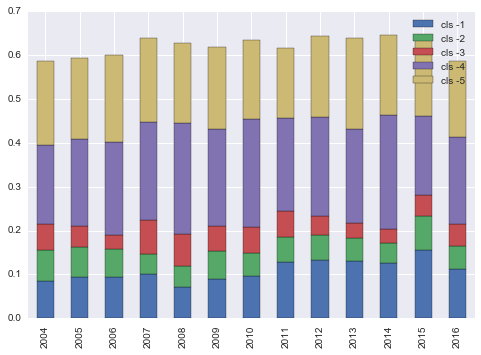

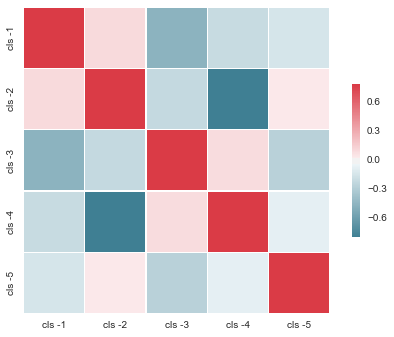

In [84]:
lanmf = nmf_pipline(ladf)

In [13]:
layr.head()

,Year,zipcode,1,2,3,4,5,6,7,8,9,10,class
0,2004,90000,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2
1,2004,90001,85.0,45.0,77.0,109.0,120.0,28.0,90.0,6.0,19.0,1.0,1
2,2004,90002,12.0,15.0,12.0,19.0,19.0,5.0,15.0,2.0,2.0,0.0,1
3,2004,90003,0.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1
4,2004,90004,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,3


In [14]:
phdf = pd.read_csv('data/phdf.csv')
sfdf = pd.read_csv('data/sfdf.csv')
louisdf = pd.read_csv('data/louisdf.csv')
dedf = pd.read_csv('data/dedf.csv')
ladf = pd.read_csv('data/ladf.csv')

In [15]:
sfdf['8'] = 0.0
sfdf = sfdf[['Year', 'Month', 'zipcode', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]

In [16]:
def get_year_data(df):
    new_df = df.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)
    new_df = get_scaled(new_df)
    return new_df

def get_scaled(df):
    cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    X = df[cols].values
    scaler = MinMaxScaler()
    X_sca = scaler.fit_transform(X)
    df[cols] = X_sca
    return df

In [17]:
frames = [ladf, sfdf, phdf, louisdf, dedf]
for idx, df in enumerate(frames):
    frames[idx] = get_year_data(df)

In [18]:
totdf = pd.concat(frames)

In [19]:
totdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6065 entries, 0 to 582
Data columns (total 12 columns):
Year       6065 non-null int64
zipcode    6065 non-null object
1          6065 non-null float64
2          6065 non-null float64
3          6065 non-null float64
4          6065 non-null float64
5          6065 non-null float64
6          6065 non-null float64
7          6065 non-null float64
8          6065 non-null float64
9          6065 non-null float64
10         6065 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 616.0+ KB


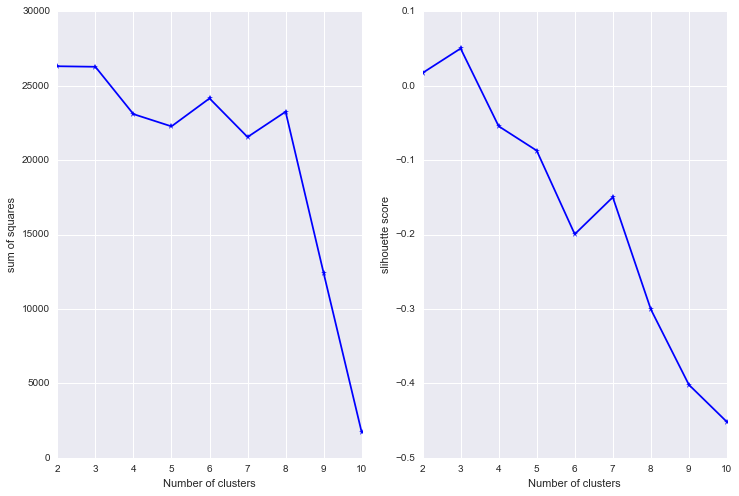

In [20]:
# nmf_test(totdf, scale=False)

In [21]:
def nmf_model(df, k=5):
    numPost = df['zipcode'].unique().shape[0]
    X = df.drop(['Year', 'zipcode'], axis=1).values
#     print X
    scaler = MinMaxScaler()
    X_sca = scaler.fit_transform(X)
    model = NMF(n_components=k)
    W = model.fit_transform(X_sca)
    labels = W.argmax(axis=1)
    H = model.components_
    plot_heatmap(H.T, k)
    return model


In [61]:
#### Build the cluster based on the LA feature matrix H
def nmf_la_based(df, model):
    numPost = df['zipcode'].unique().shape[0]
    new_df = df.groupby(['Year', 'zipcode']).sum().reset_index().drop('Month', axis=1)
    X = new_df.drop(['Year', 'zipcode'], axis=1).values
#     print X
    scaler = MinMaxScaler()
    X_sca = scaler.fit_transform(X)
    W = model.transform(X_sca)
    labels = W.argmax(axis=1)
    k = W.shape[1]
    new_df['class'] = labels
    cntClass = new_df.groupby(['Year', 'class'])['zipcode'].count().unstack().reset_index()
    X_class = cntClass.drop(['Year'], axis=1).values
    X_class = 1.0 * X_class/ numPost
    years = sorted(df['Year'].unique())
    className = ['cls -{}'.format(i+1) for i in xrange(k)]
    plot_lines(X_class, years, className)
    plot_bars(X_class, years, className)
    plt.show()



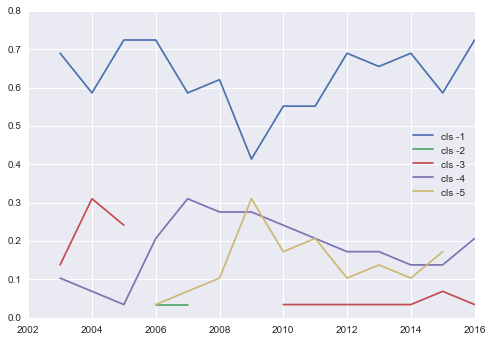

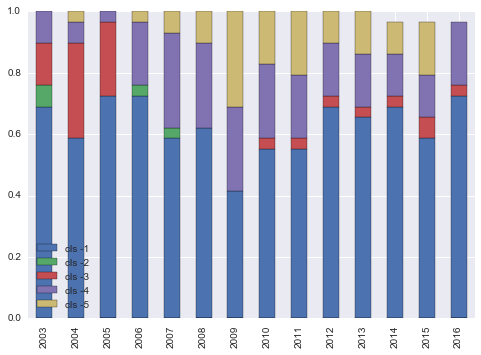

In [62]:
nmf_la_based(sfdf, lanmf)

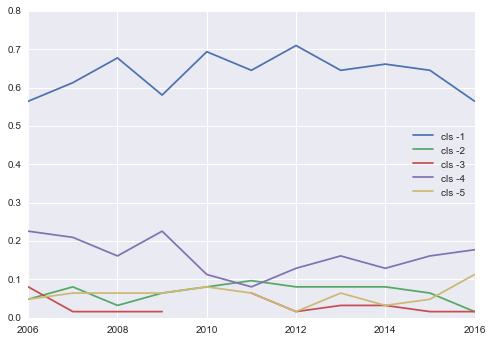

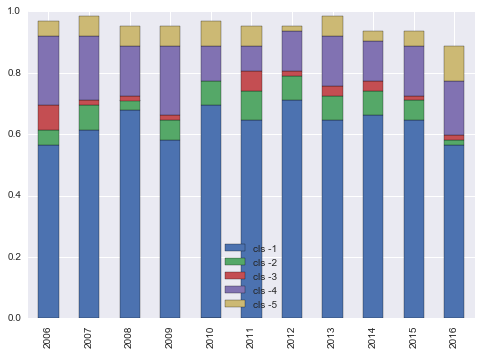

In [63]:
nmf_la_based(phdf, lanmf)

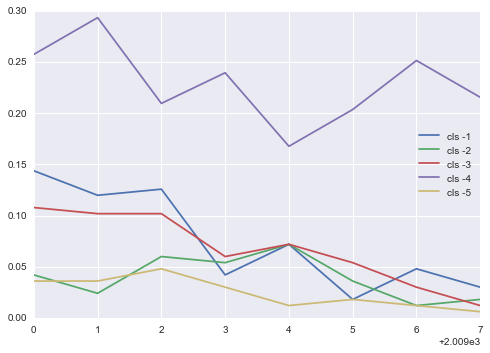

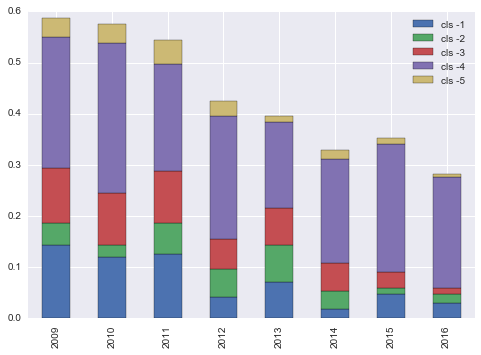

In [64]:
nmf_la_based(dedf, lanmf)

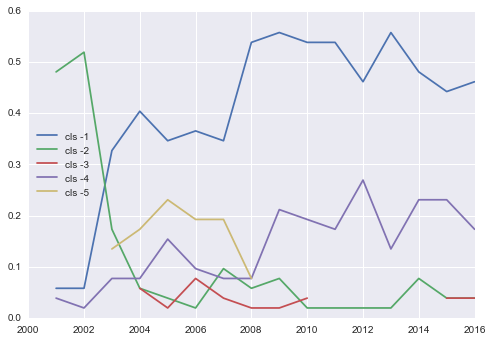

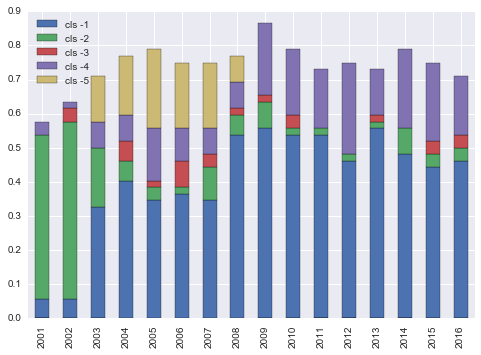

In [65]:
nmf_la_based(louisdf, lanmf)

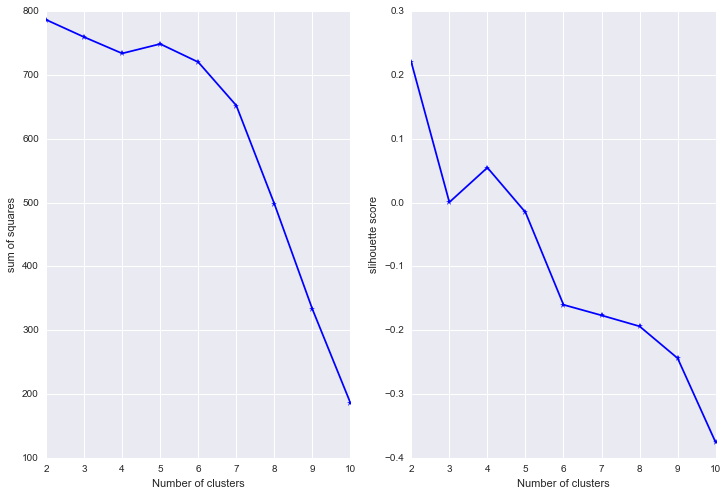

In [51]:
nmf_test(sfdf)

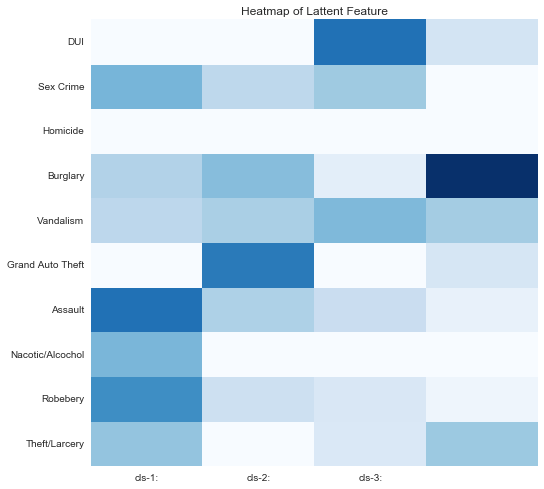

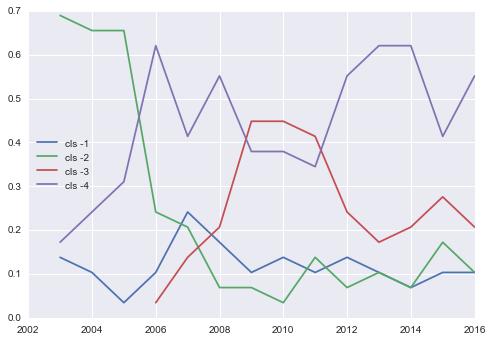

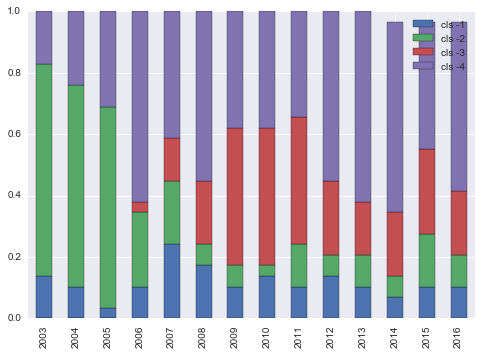

NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=4, nls_max_iter=2000, random_state=None, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [60]:
nmf_pipline(sfdf, 4)

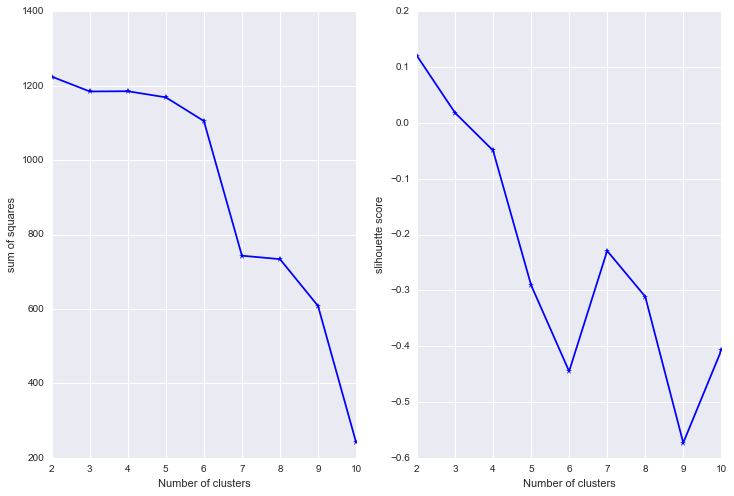

In [67]:
nmf_test(dedf)

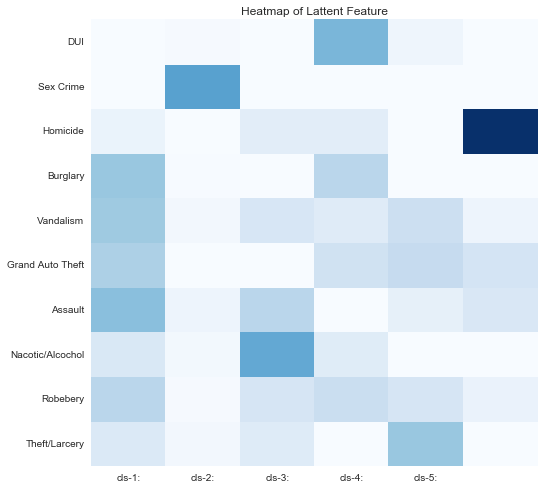

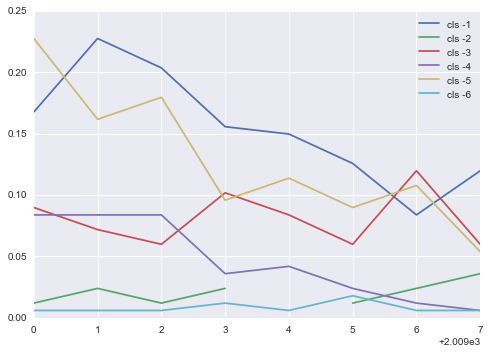

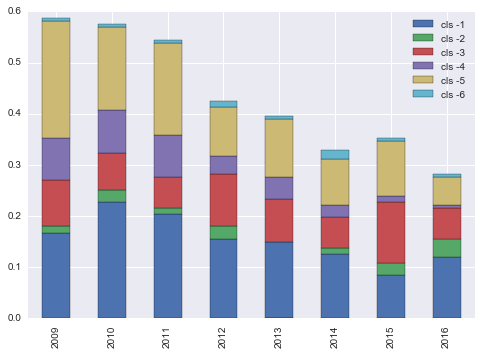

NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=6, nls_max_iter=2000, random_state=None, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [69]:
nmf_pipline(dedf, 6)